<a href="https://colab.research.google.com/github/K4tzn/bert_shap/blob/main/Text_Classification_Explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers 
!pip install datasets 
!pip install evaluate

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch.optim as optim

from sklearn.model_selection import train_test_split

#Preprocess

**Load Dataset**

In [ ]:
path = "/content/drive/MyDrive/Uni/2. Semester/Seminararbeit/Data/news.csv"
df = pd.read_csv(path)

print(df)

In [ ]:
df=pd.get_dummies(df,columns=['label'],drop_first=True)
df = df.rename(columns={'label_REAL': 'label'})
# Pre Processing

df.info()

df['titletext'] = df['title'] + ". " + df['text']
df= df.reindex(columns=['label', 'titletext'])
df = df.rename(columns={'titletext': 'text'})

df.drop( df[df.text.str.len() < 5].index, inplace=True)
# trim
first_n_words = 200

def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

df['text'] = df['text'].apply(trim_string)

print(df)

In [ ]:
from datasets import load_dataset, Dataset

train, test = train_test_split(df, test_size=0.3, shuffle=False)

trainData = Dataset.from_pandas(train)

testData = Dataset.from_pandas(test)

print(testData[0])
print(trainData[0])

{'label': 1, 'text': "7 things to watch for on election night. Washington (CNN) Donald Trump is attempting to crack Hillary Clinton's blue wall. And Clinton is hoping for a surge in Latino turnout fueled by opposition to Trump. The two candidates are making a last-minute dash across swing states like Florida, Pennsylvania and North Carolina as the 2016 presidential race enters its final hours. They've also gone north to Michigan and New Hampshire to states Democrats have won in recent cycles but could flip this year. Here are the key states and signs to study as the night unfolds: Most plausible paths to victory for Trump start with holding onto two battlegrounds that Mitt Romney won four years ago -- North Carolina and Arizona -- and flipping three states President Barack Obama carried: Florida, Ohio and Iowa. A loss in any of the states would severely complicate Trump's already precarious path to 270 electoral votes. Though if Trump clawed back Pennsylvania or Michigan from the Democ

**Preprocess**

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_trainData = trainData.map(preprocess_function, batched=True)
tokenized_testData = testData.map(preprocess_function, batched=True)

In [ ]:
#create a batch of examples using DataCollatorWithPadding
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

**Evaluate**

In [ ]:
#function that passes predictions and labels to compute to calculate accuracy
import numpy as np
from datasets import load_metric


def compute_metrics(eval_pred):
    metric1 = load_metric("accuracy")
    metric2 = load_metric("f1")
    metric3 = load_metric("precision")
    metric4 = load_metric("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric1.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = metric2.compute(predictions=predictions, references=labels)["f1"]
    precision = metric3.compute(predictions=predictions, references=labels)["precision"]
    recall = metric4.compute(predictions=predictions, references=labels)["recall"]
    return {"accuracy": accuracy, "f1":f1, "precision": precision, "recall": recall}


In [ ]:
#Map of expected ids to their labels

id2label = {0: "FAKE", 1: "REAL"}
label2id = {"FAKE": 0, "REAL": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#Train

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model_test",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs', 
    logging_steps=10,    
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_trainData,
    eval_dataset=tokenized_testData,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


In [ ]:
training_output = trainer.training_output

training_loss = training_output.losses["train"]
validation_loss = training_output.losses["eval"]

plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.show()


In [ ]:
trainer.save_model("/content/drive/MyDrive/Uni/2. Semester/Seminararbeit/Data/TrainedModel_4")

#Evaluation

In [ ]:
import evaluate
from evaluate import evaluator
from transformers import AutoTokenizer

task_evaluator = evaluator("text-classification")

trainedModel = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Uni/2. Semester/Seminararbeit/Data/TrainedModel_2")

eval_results= task_evaluator.compute(
    model_or_pipeline=trainedModel,
    data=testData,
    tokenizer=tokenizer,
    metric=evaluate.combine(["accuracy", "recall", "precision", "f1"]),
    label_mapping={"FAKE": 0, "REAL": 1}
)
print(eval_results)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


{'accuracy': 0.9852709100473435, 'recall': 0.9925053533190579, 'precision': 0.9778481012658228, 'f1': 0.9851222104144528, 'total_time_in_seconds': 35.56169568500002, 'samples_per_second': 53.456393554423364, 'latency_in_seconds': 0.018706836236191487}


In [ ]:
list_eval_results = [eval_results]

list_eval_results

# Convert evaluation results to dataframe
df_eval_results = pd.DataFrame(list_eval_results[:4])

print(df_eval_results)

   accuracy    recall  precision        f1  total_time_in_seconds  \
0  0.985271  0.992505   0.977848  0.985122              53.021709   

   samples_per_second  latency_in_seconds  
0           35.853239            0.027891  


In [ ]:
for key in testData[0].keys():
    print(key)

# Extract the true labels from testData
y_true = [int(example["label"]) for example in testData]

print(y_true)

label
text
__index_level_0__
[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [ ]:
from torch.utils.data import DataLoader

# Create a DataLoader from your test dataset
test_dataloader = DataLoader(testData, batch_size=16)

# Put the model in evaluation mode
trainedModel.eval()

# Make predictions on the test data
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        inputs = tokenizer(batch["text"], padding=True, truncation=True, return_tensors='pt').to(device)
        outputs = trainedModel(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.tolist())

In [ ]:
print(y_pred)

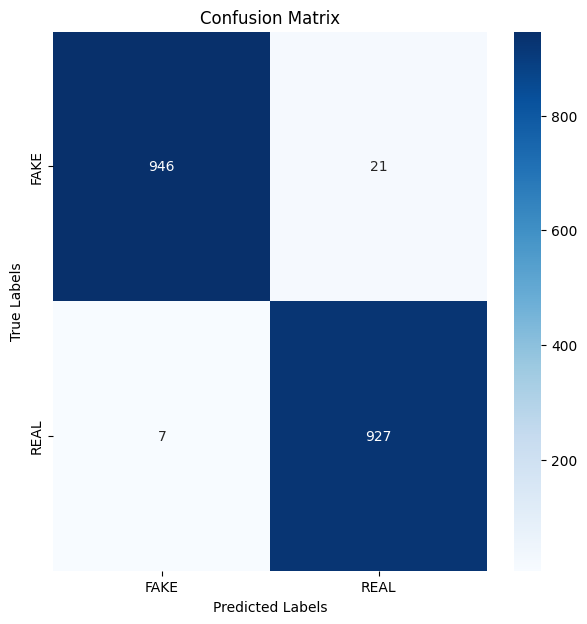

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the true labels from testData.
y_true = [int(example["label"]) for example in testData]

# Get the predicted labels using the trained model
y_pred = y_pred

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

labels = ['FAKE', 'REAL']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()

# SHAP Explainer

In [ ]:
!pip install shap
!pip install transformers
!pip install nlp

import shap
import transformers
import nlp
import torch
import numpy as np
import scipy as sp

In [ ]:
import string
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=400, truncation=True) for v in x]).cuda()
    outputs = trainedModel(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
exclude_tokens = [101, 102, tokenizer.get_vocab()['.'], tokenizer.get_vocab()[',']]

remove_chars = list(string.punctuation) + ['[PAD]', '[CLS]', '[SEP]']

def preprocess(text):
    if text is None:
        return ''
    # remove punctuation marks except for commas, periods and quotes
    punctuation = string.punctuation.replace(',', '').replace('.', '').replace('"', '')
    text = text.translate(str.maketrans('', '', punctuation))
    return text

explainer = shap.Explainer(f, tokenizer)

In [ ]:

train_data = testData
# explain the predictions of the pipeline on the first 200 samples
shap_values = explainer(train_data[:200])

In [ ]:
print("True: ")
print(y_true[:5])

print("Predicted: ")
print(y_pred[:5])

print("testData[0]: ")
print(testData[0])

True: 
[1, 1, 1, 1, 0]
Predicted: 
[1, 1, 1, 1, 0]
testData[0]: 
{'label': 1, 'text': "7 things to watch for on election night. Washington (CNN) Donald Trump is attempting to crack Hillary Clinton's blue wall. And Clinton is hoping for a surge in Latino turnout fueled by opposition to Trump. The two candidates are making a last-minute dash across swing states like Florida, Pennsylvania and North Carolina as the 2016 presidential race enters its final hours. They've also gone north to Michigan and New Hampshire to states Democrats have won in recent cycles but could flip this year. Here are the key states and signs to study as the night unfolds: Most plausible paths to victory for Trump start with holding onto two battlegrounds that Mitt Romney won four years ago -- North Carolina and Arizona -- and flipping three states President Barack Obama carried: Florida, Ohio and Iowa. A loss in any of the states would severely complicate Trump's already precarious path to 270 electoral votes. Th

**Text plot**

When we pass a single instance to the text plot we get the importance of each token overlayed on the original text that corresponds to that token. Red regions correspond to parts of the text that increase the output of the model when they are included, while blue regions decrease the output of the model when they are included.

In [ ]:
shap.plots.text(shap_values[0])

In [ ]:
shap.plots.text(shap_values[4])

**Bar plot**

Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


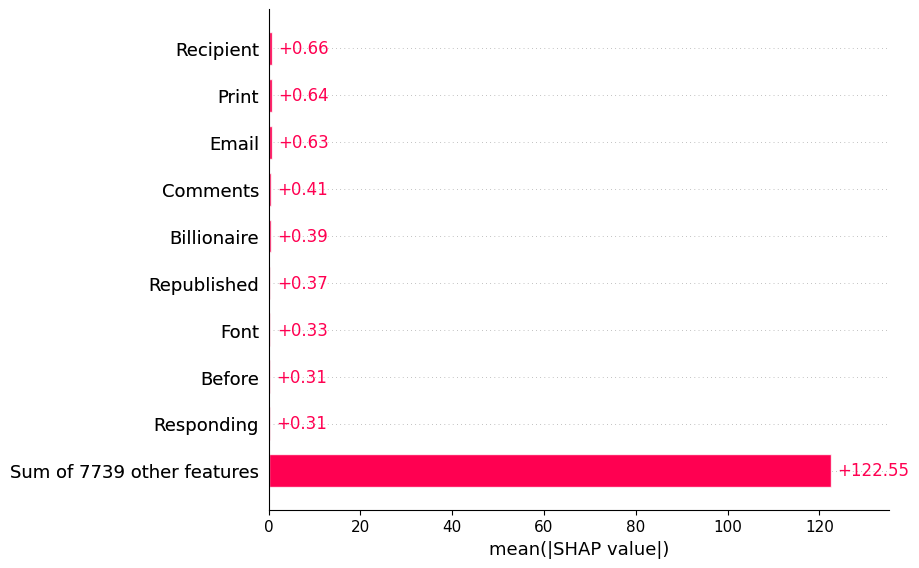

In [ ]:
shap.plots.bar(shap_values)

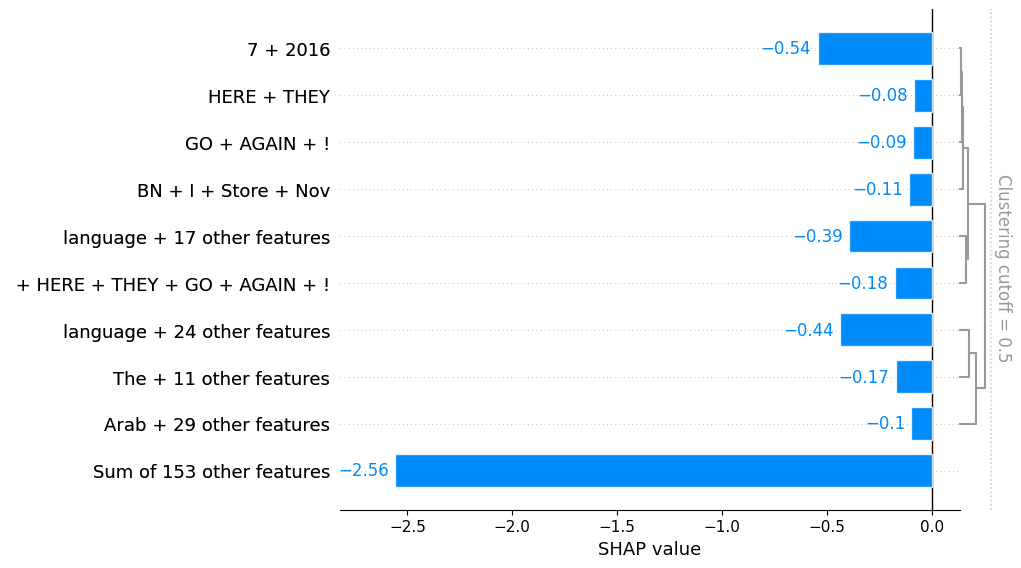

In [ ]:
shap.plots.bar(shap_values[4])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


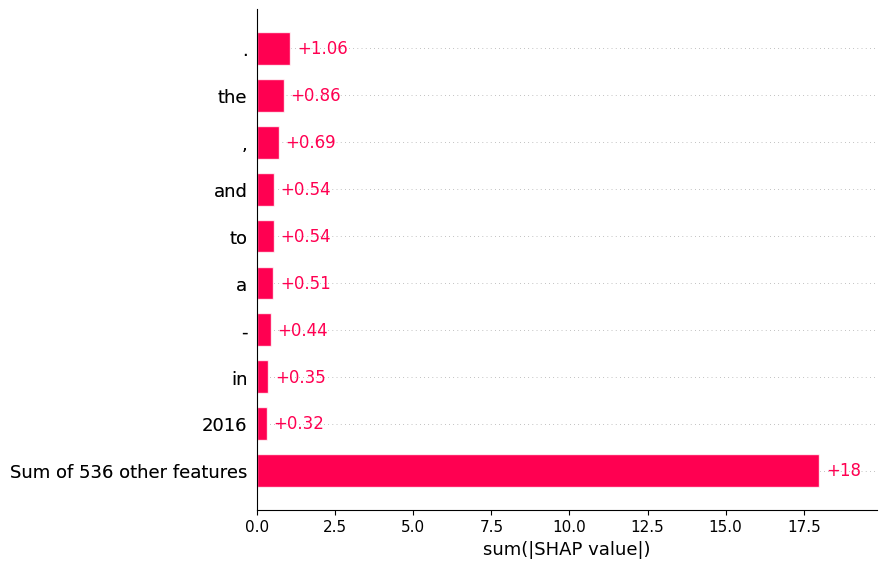

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))

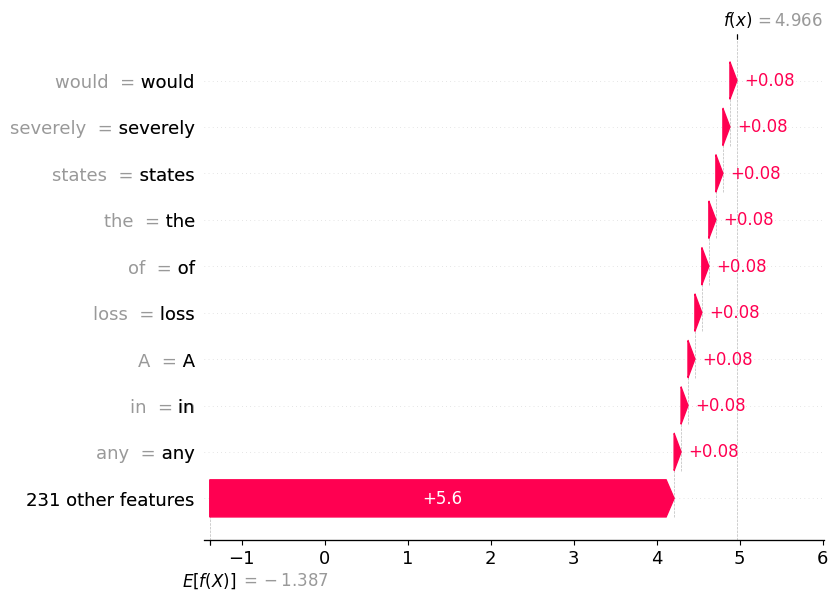

In [ ]:
shap.plots.waterfall(shap_values[0])

# LIME

In [ ]:
!pip install lime
!pip install transformers 
!pip install datasets 

from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Uni/2. Semester/Seminararbeit/Data/TrainedModel_2")

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
device = torch.device("cpu")
model.to(device)
print(device)

cpu


In [ ]:
import torch.nn.functional as F

# Instantiate explainer
explainer = LimeTextExplainer(class_names=['real','fake'])

def predictor(texts):
  outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
  probas = F.softmax(outputs.logits).detach().numpy()
  return probas


In [ ]:
exp = explainer.explain_instance(testData[0]["text"], predictor, num_features=10, num_samples = 60)
exp.show_in_notebook(text=testData[0]["text"])

In [ ]:
exp = explainer.explain_instance(testData[4]["text"], predictor, num_features=10, num_samples = 50)
exp.show_in_notebook(text=testData[4]["text"])